In [15]:
%pip install gmplot

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [16]:
from PIL import Image
import numpy as np

img = Image.open("output.jpg").convert("L")
img_arr = np.array(img)
ref_img = []
counter = 0
for row in range(len(img_arr)):
    for ele in range(len(img_arr[0])):
        if img_arr[row][ele] > 200:
            img_arr[row][ele] = 255
        elif img_arr[row][ele] < 50:
            img_arr[row][ele] = 0
        else:
            img_arr[row][ele] = 100
            ref_img.append([row, ele])
ref_coo = [[43.471806, -80.547952], [43.471175, -80.549465]]
my = (ref_coo[0][0] - ref_coo[1][0]) / (ref_img[0][0] - ref_img[1][0])
mx = (ref_coo[0][1] - ref_coo[1][1]) / (ref_img[0][1] - ref_img[1][1])

y_coo = lambda img_y : ref_coo[0][0] + (my * (img_y - ref_img[0][0]))
x_coo = lambda img_x : ref_coo[0][1] + (mx * (img_x - ref_img[0][1]))
tree = {}
for col in range(len(img_arr)):
    for row in range(len(img_arr[0])):
        if img_arr[col][row] != 255:
            neighbours = []
            for num1 in [-1, 0, 1]:
                for num2 in [-1, 0, 1]:
                    try:
                        if img_arr[col + num1][row + num2] != 255 and num1 + num2 != 0:
                            neighbours.append("(" + str(col + num1) + ", " + str(row + num2) + ")")
                    except:
                        pass
            tree["(" + str(col) + ", " + str(row) + ")"] = (neighbours, (y_coo(col), x_coo(row)))

In [17]:
import json

json_string = json.dumps(tree)

file_name = "tree.txt"

with open(file_name, 'w') as file:
    file.write(json_string)

In [32]:
from collections import deque

def find_routes(tree, start_node, max_nodes=1000):
    visited = set()
    routes = []
    queue = deque([(start_node, [start_node])])

    while queue and len(routes) < max_nodes:
        current_node, path = queue.popleft()
        if current_node not in visited:
            visited.add(current_node)
            routes.append(path)

            for neighbor in tree[current_node][0]:
                if neighbor not in visited:
                    queue.append((neighbor, path + [neighbor]))

    return routes

start_point = '(289, 898)'
possible_routes = find_routes(tree, start_point)

for route in possible_routes:
    print(route)

['(289, 898)']
['(289, 898)', '(289, 899)']
['(289, 898)', '(290, 898)']
['(289, 898)', '(289, 899)', '(289, 900)']
['(289, 898)', '(290, 898)', '(290, 897)']
['(289, 898)', '(289, 899)', '(289, 900)', '(288, 900)']
['(289, 898)', '(290, 898)', '(290, 897)', '(290, 896)']
['(289, 898)', '(290, 898)', '(290, 897)', '(291, 897)']
['(289, 898)', '(289, 899)', '(289, 900)', '(288, 900)', '(288, 901)']
['(289, 898)', '(290, 898)', '(290, 897)', '(290, 896)', '(291, 896)']
['(289, 898)', '(290, 898)', '(290, 897)', '(290, 896)', '(291, 896)', '(291, 895)']
['(289, 898)', '(290, 898)', '(290, 897)', '(290, 896)', '(291, 896)', '(291, 895)', '(292, 895)']
['(289, 898)', '(290, 898)', '(290, 897)', '(290, 896)', '(291, 896)', '(291, 895)', '(292, 895)', '(292, 894)']
['(289, 898)', '(290, 898)', '(290, 897)', '(290, 896)', '(291, 896)', '(291, 895)', '(292, 895)', '(292, 894)', '(292, 893)']
['(289, 898)', '(290, 898)', '(290, 897)', '(290, 896)', '(291, 896)', '(291, 895)', '(292, 895)', '(292

In [40]:
import gmplot

map_center = tree['(6, 253)'][1]
gmap = gmplot.GoogleMapPlotter(map_center[0], map_center[1], 12)

node_keys = list(tree.keys())
for i in range(0, len(node_keys), 5):
    node = node_keys[i]
    neighbors, coordinates = tree[node]

    gmap.marker(coordinates[0], coordinates[1], title=node, clickable=True)

    for neighbor in neighbors:
        if neighbor in tree:
            node_coords = coordinates
            neighbor_coords = tree[neighbor][1]
            edge_lats = [node_coords[0], neighbor_coords[0]]
            edge_lons = [node_coords[1], neighbor_coords[1]]
            gmap.plot(edge_lats, edge_lons, 'blue')

gmap.draw("tree_map.html")

In [41]:
source_node, target_node = '(406, 409)', '(557, 266)'
#source_node, target_node = '(289, 898)', '(385, 204)'
#source_node, target_node = '(235, 706)', '(260, 460)'

In [42]:
import heapq
from math import radians, sin, cos, sqrt, atan2, degrees

R = 6371000

def haversine(coord1, coord2):
    lat1, lon1 = map(radians, coord1)
    lat2, lon2 = map(radians, coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return round(R * c, 5)

def calculate_angle(coord1, coord2):
    dx, dy = coord2[1] - coord1[1], coord2[0] - coord1[0]
    return degrees(atan2(dy, dx))

def smooth_path(path, tree):
    smoothed_path = [path[0]]
    i = 1
    while i < len(path) - 1:
        start_node = path[i - 1]
        current_node = path[i]
        end_node = path[i + 1]
        start_coords, current_coords, end_coords = tree[start_node][1], tree[current_node][1], tree[end_node][1]
        angle_start = calculate_angle(start_coords, current_coords)
        angle_end = calculate_angle(current_coords, end_coords)

        if abs(angle_start - angle_end) < 1e-5:
            if round(angle_start) % 90 < 2:
                smoothed_path[-1] = end_node
            else:
                smoothed_path.append(path[i])
            i += 1
        else:
            smoothed_path.append(path[i])
        i += 1
    smoothed_path.append(path[-1])
    return smoothed_path

def dijkstra(tree, start, end):
    graph = {node: {n: haversine(tree[node][1], tree[n][1]) for n in tree[node][0]} for node in tree}

    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    priority_queue = [(0, start)]
    previous_nodes = {}

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)
        if current_distance > distances[current_node]:
            continue

        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    path = []
    current_node = end
    while current_node != start:
        path.insert(0, current_node)
        current_node = previous_nodes[current_node]
    path.insert(0, start)

    total_distance = sum(distances[node] for node in path[1:])
    for i in range(len(path) - 1):
        start_node, end_node = path[i], path[i + 1]
        distance = distances[end_node]
        start_coords, end_coords = tree[start_node][1], tree[end_node][1]
        angle = calculate_angle(start_coords, end_coords)
        # print(f"Move from {start_node} to {end_node}: Distance: {distance:.3f} m, Cartesian Angle: {angle:.3f} degrees")

    return path

path = dijkstra(tree, source_node, target_node)
smoothed_path = smooth_path(path, tree)

for i in range(len(smoothed_path) - 1):
    start_node, end_node = smoothed_path[i], smoothed_path[i + 1]
    start_coords, end_coords = tree[start_node][1], tree[end_node][1]
    distance = haversine(start_coords, end_coords)
    angle = calculate_angle(start_coords, end_coords)
    print(f"Move from {start_node} to {end_node}: Distance: {distance:.3f} m, Cartesian Angle: {angle:.3f} degrees")

print(f"Total distance of the path: {sum(haversine(tree[smoothed_path[i]][1], tree[smoothed_path[i+1]][1]) for i in range(len(smoothed_path) - 1)):.3f} m")
print(f'Shortest path: {" -> ".join(smoothed_path)}')

Move from (289, 898) to (290, 896): Distance: 0.668 m, Cartesian Angle: -160.053 degrees
Move from (290, 896) to (291, 896): Distance: 0.299 m, Cartesian Angle: -90.000 degrees
Move from (291, 896) to (291, 895): Distance: 0.299 m, Cartesian Angle: 180.000 degrees
Move from (291, 895) to (292, 893): Distance: 0.668 m, Cartesian Angle: -160.053 degrees
Move from (292, 893) to (293, 891): Distance: 0.668 m, Cartesian Angle: -160.053 degrees
Move from (293, 891) to (294, 891): Distance: 0.299 m, Cartesian Angle: -90.000 degrees
Move from (294, 891) to (294, 890): Distance: 0.299 m, Cartesian Angle: 180.000 degrees
Move from (294, 890) to (295, 888): Distance: 0.668 m, Cartesian Angle: -160.053 degrees
Move from (295, 888) to (296, 886): Distance: 0.668 m, Cartesian Angle: -160.053 degrees
Move from (296, 886) to (297, 886): Distance: 0.299 m, Cartesian Angle: -90.000 degrees
Move from (297, 886) to (297, 885): Distance: 0.299 m, Cartesian Angle: 180.000 degrees
Move from (297, 885) to (29

In [43]:
def plot_on_map(tree, path):
    gmap = gmplot.GoogleMapPlotter(tree[path[0]][1][0], tree[path[0]][1][1], 12)

    lats, lons = [], []
    for node in path:
        lat, lon = tree[node][1]
        lats.append(lat)
        lons.append(lon)

    gmap.plot(lats, lons, 'cornflowerblue', edge_width=5)

    gmap.marker(lats[0], lons[0], 'green')
    gmap.marker(lats[-1], lons[-1], 'red')

    gmap.draw('path_on_map.html')
    return 'path_on_map.html'

smoothed_path = smooth_path(path, tree)

plot_on_map(tree, smoothed_path)


'path_on_map.html'

In [44]:
import matplotlib.pyplot as plt
import networkx as nx

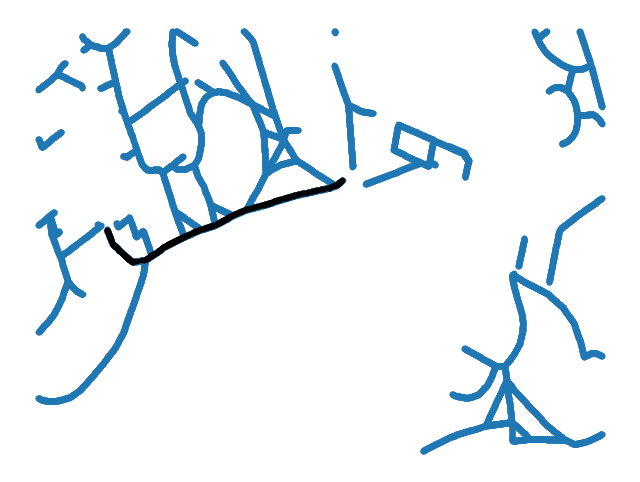

In [45]:
all_coordinates = set()
for node, (_, coords) in tree.items():
    all_coordinates.add(coords)

G = nx.Graph()

for coord in all_coordinates:
    G.add_node(coord)

rotated_flipped_coords = {
    (x, y): (y, x) for (x, y) in all_coordinates
}

pos = {coord: rotated_flipped_coords[coord] for coord in all_coordinates}

plt.figure(figsize=(8, 6))

smoothed_path_set = set(smoothed_path)

coordinates_smoothed_path = [tree[node][1] for node in smoothed_path]

for coord in coordinates_smoothed_path:
    G.add_node(coord)

nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=coordinates_smoothed_path, node_size=10, node_color='black')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

plt.axis('off')
plt.show()

/Users/rajanagarwal/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/m8/2wxq66fs2sbghj_z2wq8t2_40000gn/T/ipykernel_39809/3294301724.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(source_coords[1], source_coords[0], c=(1,0,0), label='Source Node', s=200)
/var/folders/m8/2wxq66fs2sbghj_z2wq8t2_40000gn/T/ipykernel_39809/3294301724.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword

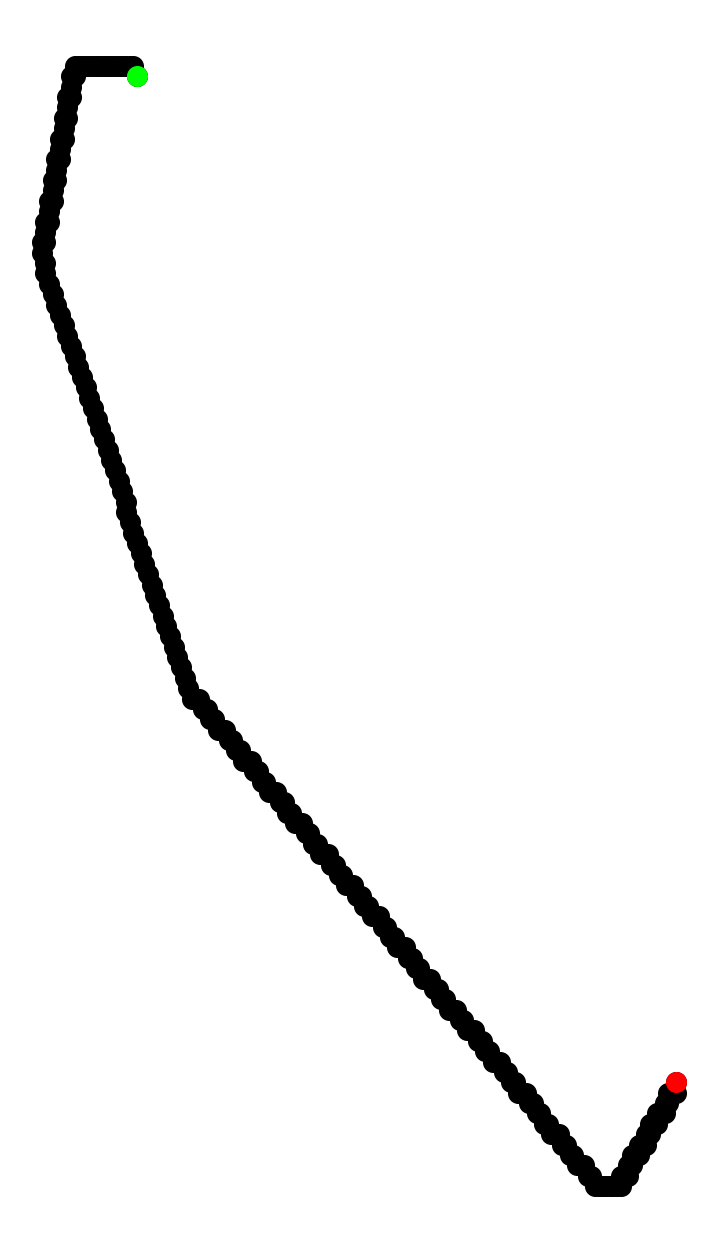

In [39]:
path = dijkstra(tree, source_node, target_node)
path_coords = [tree[node][1] for node in path]

y_coords = [coord[0] for coord in path_coords]
x_coords = [coord[1] for coord in path_coords]

poly_degree = 100
polyfit = np.polyfit(x_coords, y_coords, poly_degree)
poly = np.poly1d(polyfit)

plt.figure(figsize=(9, 16))

x_fit = np.linspace(min(x_coords), max(x_coords), 100)
y_fit = poly(x_fit)

plt.scatter(x_coords, y_coords, c='black', label='Original Path', s=200)

source_coords = tree[source_node][1]
target_coords = tree[target_node][1]

plt.scatter(source_coords[1], source_coords[0], c=(1,0,0), label='Source Node', s=200)

plt.scatter(target_coords[1], target_coords[0], c=(0,1,0), label='Target Node', s=200)

plt.axis('off')
plt.grid(False)
plt.show()

Image coordinates of the red node ((289, 898)): (-103100, 31299)


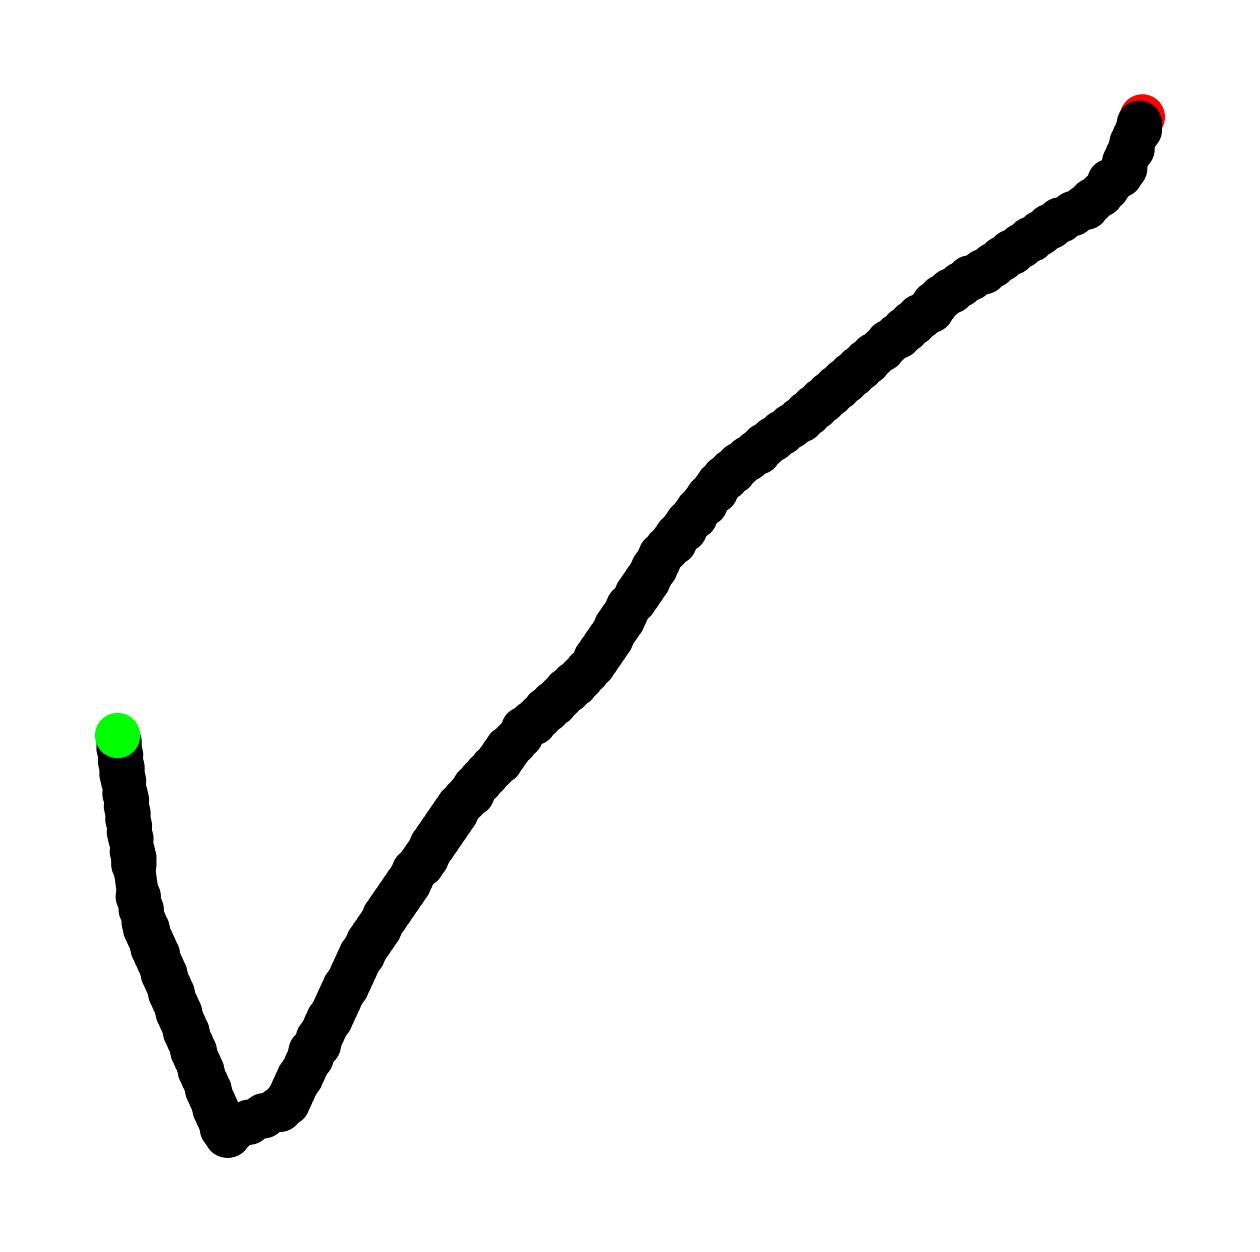

In [46]:
path = dijkstra(tree, source_node, target_node)
smoothed_path = smooth_path(path, tree)

G = nx.Graph()

for i in range(len(smoothed_path) - 1):
    start_node, end_node = smoothed_path[i], smoothed_path[i + 1]
    G.add_edge(start_node, end_node)

pos = {node: (tree[node][1][1], tree[node][1][0]) for node in tree}

plt.figure(figsize=(16, 16))

red = (1, 0, 0)
green = (0, 1, 0)

image_width = 1280
image_height = 720

red_node = smoothed_path[0]
red_node_position = pos[red_node]

image_x = int(red_node_position[0] * image_width)
image_y = int(red_node_position[1] * image_height)

print(f"Image coordinates of the red node ({red_node}): ({image_x}, {image_y})")

node_colors = [red if node == smoothed_path[0] else green if node == smoothed_path[-1] else (0, 0, 0) for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=30, alpha=1, edge_color='black')

plt.axis('off')
plt.savefig('graph_image.png', dpi=80)
plt.show()